# Constrained Orthogonal Matching Pursuit for Audio Declipping

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.signal as sig
import scipy.optimize as opt

import cvxpy as cp

## Signal Clipping

In [20]:
def clip(s, theta_clip : float):
    """ 
    Clips a signal s to the range [-theta_clip, theta_clip]
    """
    return np.clip(s, -theta_clip, theta_clip)

In [6]:
def get_theta_clip(y):
    """ 
    Returns the clipping threshold for a clipped signal y
    """
    return np.max(np.abs(y))

In [7]:
def get_M_r(y, theta_clip : float = None):
    """
    Returns the measurement matrix M_r for a clipped signal y
    s.t y_r = M_r * s
    """
    N = y.shape[0]
    M_r = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_r = np.abs(y) < theta_clip           
    M_r = M_r[I_r, :]
    return M_r

In [ ]:
def get_M_m(y, theta_clip : float = None):
    """""
    Returns the matrix M_m for a clipped signal y
    s.t y_m = M_m * sign(s) * s (complement of M_r)
    """""
    N = y.shape[0]
    M_m = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m = np.abs(y) >= theta_clip
    M_m = M_m[I_m, :]
    return M_m

In [8]:
def get_M_m_plus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_plus (which gives the indices at which the signal is clipped from above) for a clipped signal y
    """
    N = y.shape[0]
    M_m_plus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_plus = y >= theta_clip           
    M_m_plus = M_m_plus[I_m_plus, :]
    return M_m_plus

In [9]:
def get_M_m_minus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_minus (which gives the indices at which the signal is clipped from below) for a clipped signal y
    """
    N = y.shape[0]
    M_m_minus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_minus = y <= -theta_clip           
    M_m_minus = M_m_minus[I_m_minus, :]
    return M_m_minus

## Gabor Dictionary

In [10]:
params = {
    "sampling_rate": 16000,
    "frame_length": 1024,
    "frame_overlap": 768
}

# Number of atoms per dictionary
K_g = params["frame_length"]//2
# Length of the signal
N = params["frame_length"]

In [11]:
def get_gabor_dictionaries(N : int, K_g : int, weight_window):
    # Create the time-frequency grid
    T = np.arange(0, N)
    J = np.arange(0, K_g)
    J, T = np.meshgrid(J, T)
    vectorized_weight_window = np.vectorize(weight_window)

    # Dictionaries of shape (N, K_g), 2* K_g atoms in total
    gabor_cosine = vectorized_weight_window(T) * np.cos(np.pi * (J+1/2) * (T+1/2) / K_g)
    gabor_sine = vectorized_weight_window(T) * np.sin(np.pi * (J+1/2) * (T+1/2) / K_g)

    return gabor_cosine, gabor_sine

In [13]:
gabor_cosine, gabor_sine = get_gabor_dictionaries(N, K_g)

In [14]:
gabor_cosine.shape, gabor_sine.shape

((1024, 512), (1024, 512))

## Orthogonal Matching Pursuit

In [15]:
def least_squares(y : np.ndarray, M_r : np.ndarray, Omega : list, D_c : np.ndarray, D_s : np.ndarray, W_c : np.ndarray, W_s : np.ndarray,
                  theta_clip : float = None, theta_max : float = None, M_m_plus : np.ndarray = None, M_m_minus : np.ndarray = None, lambda_reg : float = 0):
    """
    Solves the following least squares problem
        min_{x_c, x_s} ||y - D_c * x_c - D_s * x_s||^2 + lambda * ||x_c||^2 + lambda * ||x_s||^2     s.t.     ...

    Inputs:
    -------
    y : np.ndarray
        The signal to be reconstructed
    M_r : np.ndarray
        The measurement matrix
    Omega : list
        The indices of the measurements
    D_c : np.ndarray
        The dictionary of cosine atoms
    D_s : np.ndarray
        The dictionary of sine atoms
    W_c : np.ndarray
        The window function for the cosine atoms
    W_s : np.ndarray
        The window function for the sine atoms
    theta_clip : float
        The clipping threshold
    theta_max : float
        The maximum amplitude of the signal
    M_m_plus : np.ndarray
        The matrix M_m_plus
    M_m_minus : np.ndarray
        The matrix M_m_minus
    lambda_reg : float
        The regularization parameter

    Outputs:
    --------
    x_c : np.ndarray
        The coefficients of the cosine atoms
    x_s : np.ndarray
        The coefficients of the sine atoms
    """
    y_r = M_r @ y
    D = np.concatenate(((D_c @ W_c)[:,Omega], (D_s @ W_s)[:,Omega]), axis=1)
    D_r = M_r @ D

    if theta_clip is not None or theta_max is not None:
        ## Partie OLS avec contrainte: bcp de bugs encore, marche pas tres bien

        if M_m_plus is None:
            M_m_plus = get_M_m_plus(y, theta_clip)
        if M_m_minus is None:
            M_m_minus = get_M_m_minus(y, theta_clip)

        x = cp.Variable(D_r.shape[1])
        obj = cp.Minimize(cp.sum_squares(y_r - D_r @ x))
        
        constraints = [M_m_plus @ D @ x >= theta_clip, M_m_minus @ D @ x <= - theta_clip] if theta_clip is not None else []      # Min constraints
        constraints += [M_m_plus @ D @ x <= theta_max, M_m_minus @ D @ x >= - theta_max] if theta_max is not None else []        # Max constraints

        prob = cp.Problem(obj, constraints)
        prob.solve()
        if prob.status == 'infeasible':
            print("Infeasible problem")
            x = np.linalg.lstsq(D, y, rcond=None)[0]
        else:
            x = x.value

    else:
        x = np.linalg.lstsq(D, y, rcond=None)[0]

    x_c = x[:D_c[:,Omega].shape[1]]
    x_s = x[D_c[:,Omega].shape[1]:]
    return x_c, x_s

In [17]:
def OMP(y : np.ndarray, K : int, eps : float, 
        D_c : np.ndarray = gabor_cosine, D_s : np.ndarray = gabor_sine, theta_clip : float = None, theta_max : float = None, verbose : bool = True):
    """ 
    Runs the Orthogonal Matching Pursuit algorithm, using Gabor Dictionaries.

    Inputs:
    --------
    y: np.array
        Input signal of size N
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    verbose: bool
        If True, prints the residual norm at each iteration

    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y
    x_c: np.array
        Sparse activations of the cosine atoms 
    x_s: np.array
        Sparse activations of the sine atoms
    residual_norms : list
        List of the squared norms of the residuals at each iteration
    """

    K_g = D_c.shape[1]

    # Partition the samples of the signal
    M_r = get_M_r(y, theta_clip)                                           # Of shape (N_r, N)
    M_m_plus = get_M_m_plus(y, theta_clip) if theta_clip is not None else None
    M_m_minus = get_M_m_minus(y, theta_clip) if theta_clip is not None else None

    # Reliable samples of the signal
    y_r = M_r @ y                                                          # Of shape (N_r)

    # Dictionaries
    W_c = np.diag(1 / np.linalg.norm(M_r @ D_c, axis=0))                   # W_j,j = 1/||M_r * d_j||, j = 0, ..., K_g-1, of shape (K_g, K_g)
    W_s = np.diag(1 / np.linalg.norm(M_r @ D_s, axis=0))
    d_c_norm = M_r @ D_c @ W_c                                             # Of shape (N_r, K_g)
    d_s_norm = M_r @ D_s @ W_s

    # Array containing <d_norm_j^c|d_norm_j^s>, j = 0, ..., K_g-1, of shape (K_g)
    d_cs_dot = np.zeros(K_g)
    for j in range(K_g):
        d_cs_dot[j] = np.dot(d_c_norm[:,j], d_s_norm[:,j])

    # Residual and support
    r = y_r
    Omega = []
    residual_norms = [np.linalg.norm(y_r)**2]


    for k in range(K):

        # Atom selection
        x_c = (np.dot(r, d_c_norm) - d_cs_dot * np.dot(r, d_s_norm)) / (1 - d_cs_dot**2)
        x_s = (np.dot(r, d_s_norm) - d_cs_dot * np.dot(r, d_c_norm)) / (1 - d_cs_dot**2)
        proj = np.zeros(K_g)
        for j in range(K_g):
            if j not in Omega:
                proj[j] = np.linalg.norm(r - x_c[j] * d_c_norm[:,j] - x_s[j] * d_s_norm[:,j])**2
            else:
                proj[j] = np.inf          # Do not choose j if it is already in Omega
        i = np.argmin(np.abs(proj))

        # Update support and residual
        Omega.append(i)
        x_c2, x_s2 = least_squares(y, M_r = M_r, Omega = Omega, D_c = D_c, D_s = D_s, W_c = W_c, W_s = W_s, theta_clip = theta_clip, theta_max = theta_max, M_m_plus = M_m_plus, M_m_minus = M_m_minus)
        x_c, x_s = np.zeros(K_g), np.zeros(K_g)
        x_c[Omega] = x_c2
        x_s[Omega] = x_s2

        r = y_r - np.dot(d_c_norm[:,Omega], x_c2) - np.dot(d_s_norm[:,Omega], x_s2)
        r_norm = np.linalg.norm(r)**2
        residual_norms.append(r_norm)

        if verbose:
            print(f"Iteration {k}: residual norm {r_norm:.5f}.")

        # Stopping criterion
        if r_norm < eps:
            if verbose:
                print(f"Stopping criterion reached before selecting {K} atoms")
            break
    
    # Output
    x_c = W_c @ x_c
    x_s = W_s @ x_s
    y_reconstructed = D_c @ x_c + D_s @ x_s
    return y_reconstructed, x_c, x_s, residual_norms

In [24]:
def inpainting(y, frame_length : int = 1024, frame_overlap : int = 768, K : int = 50, eps : float = 1e-6, D_c = gabor_cosine, D_s = gabor_sine, theta_clip = None, theta_max = None):
    """
    Segments a signal y into overlapping frames of length frame_length and overlap frame_overlap
    Then runs OMP on each frame to inpaint the missing samples
    Then reconstructs the signal using OLA

    Inputs:
    -------
    y: np.array
        Input signal of size N
    frame_length: int  
        Length of the frames   
    frame_overlap: int
        Overlap between the frames
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    
    Remark : Ensure a 75% overlap between the frames and 1024 points per frame

    
    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y using the sparse activations of the atoms
    """

    N = len(y)
    w_a = sig.boxcar(frame_length) #analysis window
    w_s = np.sin(np.pi * np.arange(frame_length) / (frame_length - 1)) #synthesis window
    t_i_s = np.arange(0, N, frame_length - frame_overlap) #frames starting dates

    y_reconstructed = np.zeros(N)

    for i in t_i_s:
        y_i = w_a * y[i:i+frame_length]
        y_i_reconstructed, x_c_i, x_s_i, _ = OMP(y_i, K, eps, D_c, D_s, theta_clip = theta_clip, theta_max = theta_max, verbose = False)
        y_reconstructed[i:i+frame_length] += w_s * y_i_reconstructed

    return y_reconstructed

## Data

### Dataset

In [233]:
# Synthetic data generation
# TODO: Modifier la maniere dont choisir les coefficients
def generate_synthetic_dataset(M, N, K, theta_clip : float = .8, D_c = gabor_cosine, D_s = gabor_sine, sigma : float = 0.1):
    """
    Generates M waveforms of length N. Each waveform is a sum of K Gabor atoms and some noise. Both the original signal and the signal clipped at theta_clip are returned, along with the grounD-truth vector x.
    """
    K_g = D_c.shape[1]

    X = np.zeros((M, 2*K_g))
    Y = np.zeros((M, N))
    Y_clipped = np.zeros((M, N))

    for i in range(M):
        y = np.zeros(N)
        for k in range(K):
            j = np.random.randint(0, K_g//4)
            a = .2 * np.random.randn()
            b = .2 * np.random.randn()
            y += a * D_c[:,j] + b * D_s[:,j]
            X[i, j] += a
            X[i, K_g+j] += b
        Y[i] = y + sigma * np.random.randn(N)
        Y_clipped[i] = clip(Y[i], theta_clip)
    
    return X, Y, Y_clipped


In [221]:
## TODO: find some real data, and add a function to load some real data

### Exploratory Data Analysis

## Experiments

In [222]:
# Idees
## SNR_m vs theta_clip
## Impact of lambda_reg ?
## 

In [242]:
x, y, y_trimmed = generate_synthetic_dataset(1, N, 10, theta_clip = .9, sigma = 0.1)

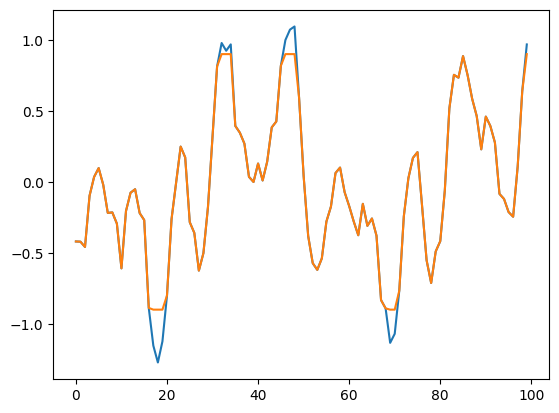

In [243]:
plt.plot(y[0][:100])
plt.plot(y_trimmed[0][:100])

In [244]:
y_reconstructed = OMP(y_trimmed[0], K = 200, eps = 1e-6, theta_clip = None, theta_max= None)[0]

Iteration 0: residual norm 133.18319.
Iteration 1: residual norm 108.35899.
Iteration 2: residual norm 88.27465.
Iteration 3: residual norm 65.92187.
Iteration 4: residual norm 46.89387.
Iteration 5: residual norm 34.21692.
Iteration 6: residual norm 24.13178.
Iteration 7: residual norm 14.17730.
Iteration 8: residual norm 10.34773.
Iteration 9: residual norm 10.21284.
Iteration 10: residual norm 10.06060.
Iteration 11: residual norm 9.92448.
Iteration 12: residual norm 9.77800.
Iteration 13: residual norm 9.65326.
Iteration 14: residual norm 9.53860.
Iteration 15: residual norm 9.42979.
Iteration 16: residual norm 9.33464.
Iteration 17: residual norm 9.24086.
Iteration 18: residual norm 9.13299.
Iteration 19: residual norm 9.04275.
Iteration 20: residual norm 8.95204.
Iteration 21: residual norm 8.87256.
Iteration 22: residual norm 8.79178.
Iteration 23: residual norm 8.71309.
Iteration 24: residual norm 8.64301.
Iteration 25: residual norm 8.56978.
Iteration 26: residual norm 8.50562

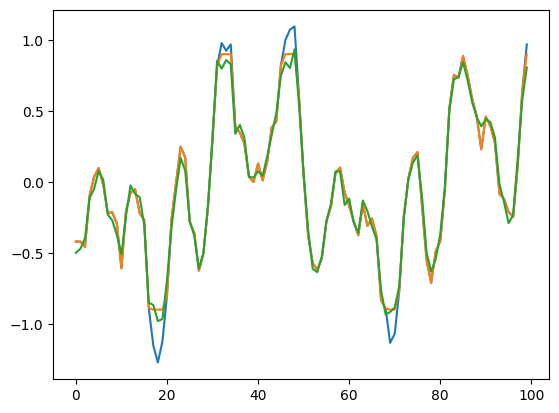

In [245]:
plt.plot(y[0][:100])
plt.plot(y_trimmed[0][:100])
plt.plot(y_reconstructed[:100])